In [1]:
import time
import math
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# The aim of this notebook is to do an exploratory data analysis of health insurance data, and then use a linear regression model to be able to predict health insurance charges.

* An exploratory data analysis
* Univariate linear regression from scratch
* Multivariate linear regression from scratch
* Linear regression using the normal equation method

## The exploratory data analysis

In [2]:
df = pd.read_csv('insurance.csv')
print(df.head())
print(df.info())
print(df.isnull().sum())
print(df['region'].unique())

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges

The data given is quite a small data-set with only 1338 people. There are a set of features describing the age, sex, bmi and reigion for each instance, as well as information on the number of children and whether they are a smoker or not. There are four categories in the region: southeast, southwest, northeast and northwest. The data is completely clean with no typos or missing data.

This is all compared against the charges on the health insurance.

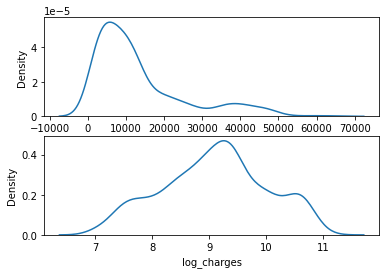

In [3]:
df['log_charges'] = np.log(df['charges'])

fig, ax = plt.subplots(nrows=2)
sns.distplot(df['charges'], ax=ax[0], hist=False)#.set_title('charges')
sns.distplot(df['log_charges'], ax=ax[1], hist=False)#.set_title('log charges')
plt.show()

The distribution of the charges shows a the data is positively skewed. When the log is taken, the data looks much better. The presence of peaks in the distribution suggests to me there are groups within the instances.

In [4]:
print('bmi correlation - ', df['charges'].corr(df['bmi']))
print('age correlation - ', df['charges'].corr(df['age']))

bmi correlation -  0.19834096883362892
age correlation -  0.29900819333064765


There is a significant correlation between both bmi and age with charges. I am slightly surprised at how low the correlation is though, especially with bmi which I would have thought would have a significant effect on health. I will look into why this is later.

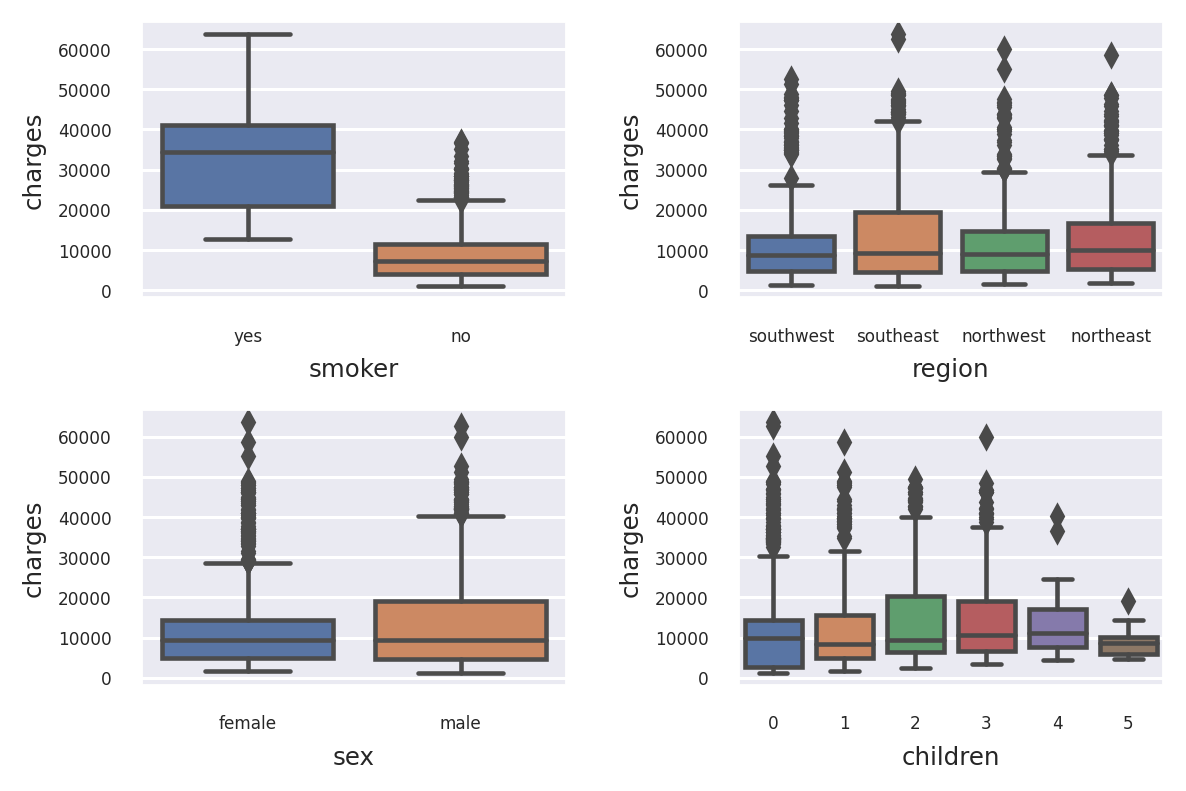

0    574
1    324
2    240
3    157
4     25
5     18
Name: children, dtype: int64


In [5]:
sns.set(font_scale = 0.5)

fig = plt.figure(dpi=220)
plt.rcParams["axes.labelsize"] = 8
fig.subplots_adjust(hspace=0.4, wspace=0.4)
ax = fig.add_subplot(2, 2, 1)
sns.boxplot(data=df, x='smoker', y='charges', ax=ax)
ax = fig.add_subplot(2, 2, 2)
sns.boxplot(data=df, x='region', y='charges', ax=ax)
ax = fig.add_subplot(2, 2, 3)
sns.boxplot(data=df, x='sex', y='charges', ax=ax)
ax = fig.add_subplot(2, 2, 4)
sns.boxplot(data=df, x='children', y='charges', ax=ax)
plt.show()
sns.set(font_scale = 1)

print(df['children'].value_counts())

With the categorical data, it is clear the biggest correlation to charges is with smoking. There appears to be some correlation with sex and region but not large. The number of children seems to have some effect on the charges but I am not sure how significant it is. Firstly the number of instances with 4 or 5 children is very low so I would not trust that data. Secondly, the 0 children category does not seem to fit an overall trend. I would therefore split this category up for a linear regresssion analysis into its contituent categories, rather than leave it as an ordinal feature (0-5).

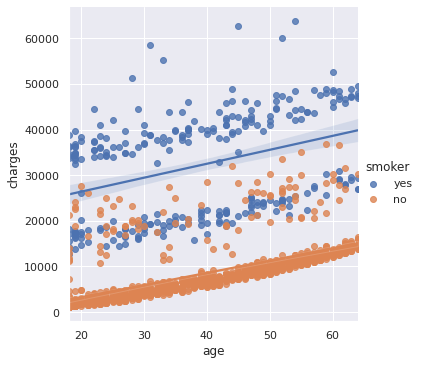

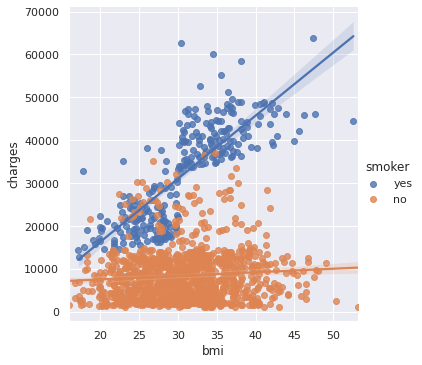

In [6]:
sns.lmplot(data=df, x='age', y='charges', hue='smoker')
plt.show()
sns.lmplot(data=df, x='bmi', y='charges', hue='smoker')
plt.show()

The scatter plot of age and charges shows there is an obvious distinction with how the smoking and non-smoking instances are treated. The smokers appear to be split again into another two groups while the non-smoking is probably all one group but with a set of outliers. These will probably be due to some other health concerns and is probably mirrored in in the smoking group; you can see the set of outliers at the top of the plot.

The scatter plot of bmi against charges shows this distinction between smokers and non-smokers again. Here though we see how the smoker group is subdivided: those with below and those with above a bmi of 30. There does not appear to be the same distinction for non-smokers. We cannot see from these plots what would cause the particularly high charges in some instances.

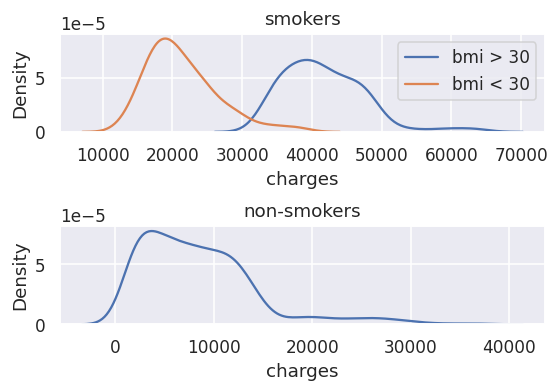

In [7]:
fig, ax = plt.subplots(nrows=2, dpi=110)
fig.tight_layout(pad=3.0)
sns.distplot(df[(df['smoker'] == 'yes') & (df['bmi'] > 30)]["charges"], ax=ax[0], hist=False,
             label='bmi > 30').set_title('smokers')
sns.distplot(df[(df['smoker'] == 'yes') & (df['bmi'] < 30)]["charges"], ax=ax[0], hist=False, label='bmi < 30')
sns.distplot(df[(df['smoker'] == 'no')]["charges"], ax=ax[1], hist=False).set_title('non-smokers')
ax[0].legend()
plt.show()

With this knowledge in mind we can now show the distribution of charges but split it into our three easily defined groups: non-smokers, smokers with bmi > 30 and smokers with bmi <30. As predicted there is a tail on some of the peak which we can see on the above scatter plots as (outlier) although it is very consistent so these will be for some medical reason. Interestingly, the same tail does not exist in the smokers with bmi < 30.

We will inesitigate whether one of the other features can account for these instances later.

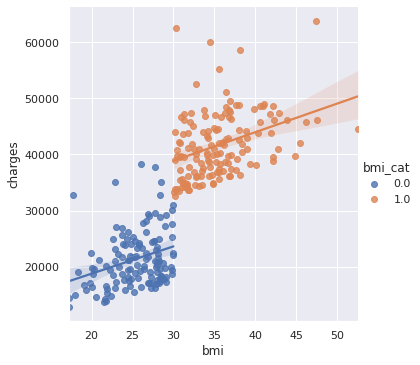

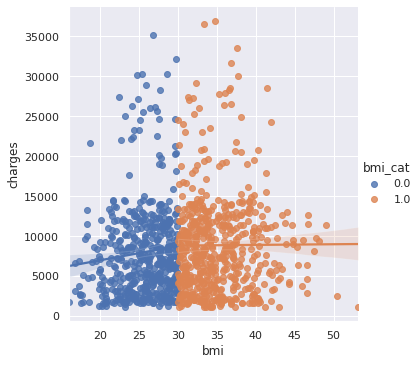

In [8]:
df['bmi_cat'] = np.nan
df.loc[df['bmi'] <= 30, 'bmi_cat'] = 0
df.loc[df['bmi'] > 30, 'bmi_cat'] = 1

sns.lmplot(data=df[df['smoker'] == 'yes'], x='bmi', y='charges', hue='bmi_cat')
plt.show()
sns.lmplot(data=df[df['smoker'] == 'no'], x='bmi', y='charges', hue='bmi_cat')
plt.show()

It seems important to split the smokers and non-smokers into different groups to fit a line trhough them. The comparison to the above lmplot with them combined shows a completely different gradient of the line of best fit. We can see that actually having a bmi of over 30 doesnt change the gradiant but the bias is significantly increased. 

Finally, we confirm that there is no split of the non-smokers along the bmi = 30 line.

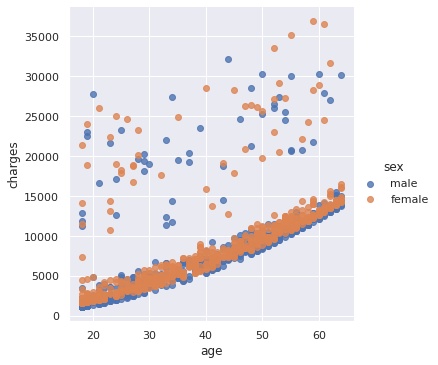

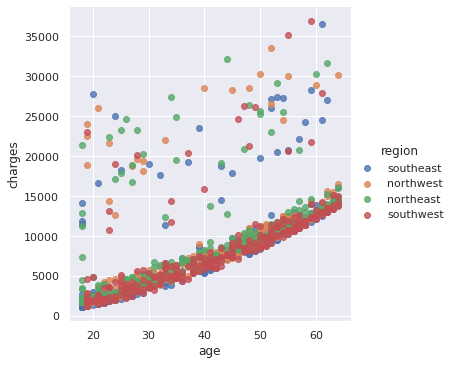

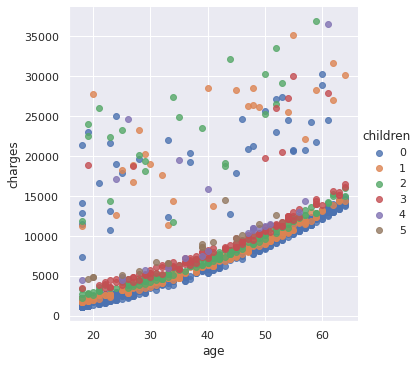

In [9]:
sns.lmplot(data=df[df['smoker'] == 'no'], x='age', y='charges', hue='sex', fit_reg=False)
plt.show()
sns.lmplot(data=df[df['smoker'] == 'no'], x='age', y='charges', hue='region', fit_reg=False)
plt.show()
sns.lmplot(data=df[df['smoker'] == 'no'], x='age', y='charges', hue='children', fit_reg=False)
plt.show()

Here we are looking for a reason for the unusually high charges on some instances. We have taken the non-smokers but can find no correlation between any of our remaining features. This suggests a medical reason which is not in our data. We therefor will not be able to model this and it will certainly cause some error in our final model. However, the number of instances and the spread is far to consistent to assume these are outliers and remove them.

We can also see some exponential behaviour. This will need to be included when making a predictive model.

In [10]:
print('bmi correlation (smokers) - ', df[df['smoker'] == 'yes']['charges'].corr(df['bmi']), '\n')
print('bmi correlation (smokers & bmi > 30) - ', 
      df[(df['smoker'] == 'yes') & (df['bmi'] > 30)]["charges"].corr(df['bmi']))
print('bmi correlation (smokers & bmi < 30) - ', 
      df[(df['smoker'] == 'yes') & (df['bmi'] > 30)]['charges'].corr(df['bmi']), '\n')
print('bmi correlation (non-smokers) - ', df[(df['smoker'] == 'no')]['charges'].corr(df['bmi']))
print('age correlation (smokers) - ', df[df['smoker'] == 'yes']['charges'].corr(df['age']))
print('age correlation (non-smokers) - ', df[(df['smoker'] == 'no')]['charges'].corr(df['age']))

bmi correlation (smokers) -  0.8064806070155404 

bmi correlation (smokers & bmi > 30) -  0.3650624941873683
bmi correlation (smokers & bmi < 30) -  0.3650624941873683 

bmi correlation (non-smokers) -  0.08403654312833268
age correlation (smokers) -  0.3682244437307778
age correlation (non-smokers) -  0.6279467837664195


We can now see correlations for our groups. As indicated earlier, the correlation between bmi and charges for smokers is probably not so large but just has a shift upwards at bmi=30. Interestingly we see almost no correlation between charges and bmi for non-smokers.

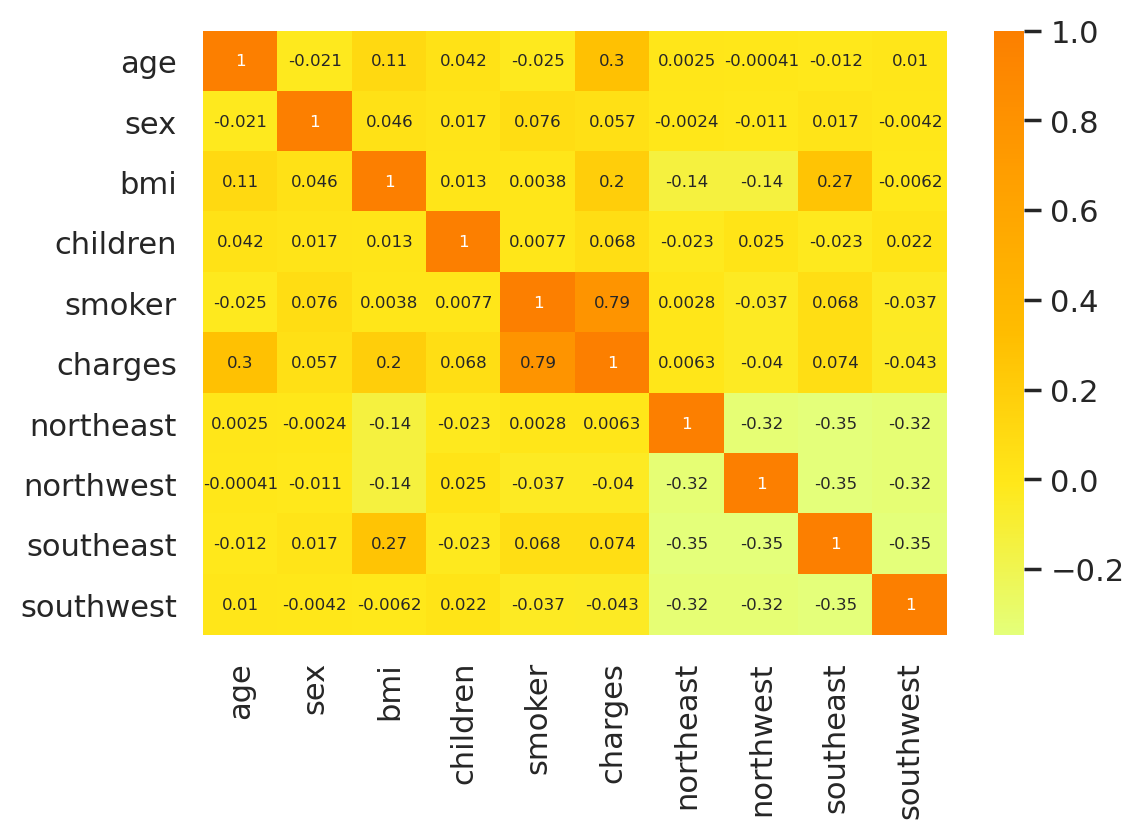

In [11]:
df['smoker'].replace(('yes', 'no'), (1, 0), inplace=True)
df['sex'].replace(('male', 'female'), (1, 0), inplace=True)

dummies = pd.get_dummies(df['region'])
df = pd.concat((df, dummies), axis = 1)
df = df.drop('region', axis = 1)

df_corr = df.drop(['log_charges', 'bmi_cat'], axis = 1)
corr = df_corr.corr()
fig, ax = plt.subplots(dpi=200)
sns.heatmap(corr, cmap = 'Wistia', annot= True, ax=ax, annot_kws={"size": 6})
plt.show()

There are no large correlations with charges other than bmi, age and obviously smoker. Here we are also looking for correlations between the features. We see a correlation between people living in the southeast and bmi which we should look out for when buliding the model.

In [12]:
df_children = df[['charges', 'children']]

dummies_children = pd.get_dummies(df_children['children'])
df_children = pd.concat((df_children, dummies_children), axis = 1)
df_children = df_children.drop('children', axis = 1)

print('0 children - ', df_children['charges'].corr(df_children[0]))
print('1 children - ', df_children['charges'].corr(df_children[1]))
print('2 children - ', df_children['charges'].corr(df_children[2]))
print('3 children - ', df_children['charges'].corr(df_children[3]))
print('4 children - ', df_children['charges'].corr(df_children[4]))
print('5 children - ', df_children['charges'].corr(df_children[5]))

0 children -  -0.06476047639409546
1 children -  -0.025180354353601806
2 children -  0.06963892513022256
3 children -  0.06279529451603874
4 children -  0.006613915717664698
5 children -  -0.04325837294882492


There are some slight correlations between the number of children and charges but no overall trend so we were right to split this feature up.

## Univariate linear regression from scratch

Now I will demonstrate linear regression with just one variable from scratch. In this case we will choose a feature that we know has good correlation with charges. We will therefore choose age for non-smokers.

In [13]:
def linear_func(X, th0, th1):
    return (X * th1) + th0

def cost_func(X, y, th0, th1):
    mm = len(X)
    return (1/2*mm) * np.sum((linear_func(X, th0, th1) - y)**2)

def grad_descent_th0(X, y, alpha, th0, th1):
    mm = len(X)
    return (alpha / mm) * np.sum(linear_func(X, th0, th1) - y)

def grad_descent_th1(X, y, alpha, th0, th1):
    mm = len(X)
    return (alpha / mm) * np.sum((linear_func(X, th0, th1) - y)*X)

* The linear func is just the function for a line. $$y = \theta_{1}X + \theta_{0}$$
* The cost function gives us an indication of the accuracy of our linear function. It compares the generated y values (from the given x values) with the given y values. A cost of 0 would indicate a very good fit to the data.
* grad_descent_th0 is the partial derivative of the cost function with respect to theta0 and timesed by alpha (the learning rate).
* grad_descent_th1 is the partial derivative of the cost function with respect to theta1 and timesed by alpha (the learning rate).

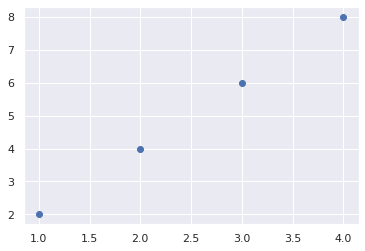

theta0 -  -4.9883369322054325e-06
theta1 -  2.000001696642868
final cost -  3.324681291387064e-11


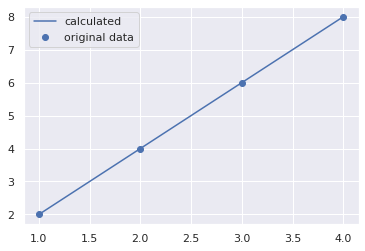

In [14]:
X = np.array([1,2,3,4])
y = np.array([2,4,6,8])

plt.scatter(X, y)
plt.show()

th0 = -15
th1 = 16
alpha = 0.1
loops = 1000

for ii in range(loops):
    temp_th0 = th0 - grad_descent_th0(X, y, alpha, th0, th1)
    temp_th1 = th1 - grad_descent_th1(X, y, alpha, th0, th1)
    th0 = temp_th0
    th1 = temp_th1
    
print('theta0 - ', th0)
print('theta1 - ', th1)
print('final cost - ', cost_func(X, y, th0, th1))

plt.plot(X, linear_func(X, th0, th1), label='calculated')
plt.scatter(X, y, label='original data')
plt.legend()
plt.show()

This demonstrates the linear regression algorithm on a very simple data set. The $\theta_{0}$ and $\theta_{1}$ values should be 0 and 2 respectively.

In [15]:
X = df[df['smoker'] == 0]['age'].values
y = df[df['smoker'] == 0]['charges'].values
print(df.head())
print(X[:5])
print(y[:5])

   age  sex     bmi  children  smoker      charges  log_charges  bmi_cat  \
0   19    0  27.900         0       1  16884.92400     9.734176      0.0   
1   18    1  33.770         1       0   1725.55230     7.453302      1.0   
2   28    1  33.000         3       0   4449.46200     8.400538      1.0   
3   33    1  22.705         0       0  21984.47061     9.998092      0.0   
4   32    1  28.880         0       0   3866.85520     8.260197      0.0   

   northeast  northwest  southeast  southwest  
0          0          0          0          1  
1          0          0          1          0  
2          0          0          1          0  
3          0          1          0          0  
4          0          1          0          0  
[18 28 33 32 31]
[ 1725.5523   4449.462   21984.47061  3866.8552   3756.6216 ]


To work with the health insurance data we have I have chosen a group of the data with a fairly good correlation and without obvious subgroups.

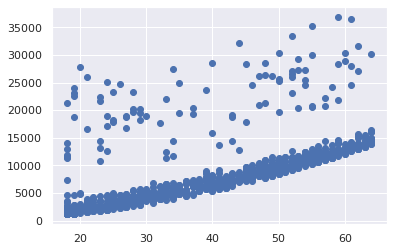

initial cost -  53993128354144.91
theta0 -  -2091.3953745523404
theta1 -  267.24834584340255
final cost -  12305294843659.188


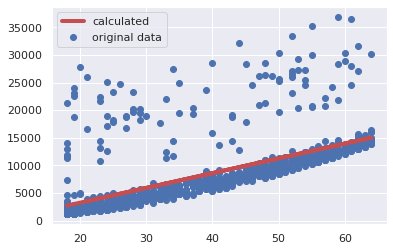

In [16]:
plt.scatter(X, y)
plt.show()

th0 = -15
th1 = 16
alpha = 0.001
loops = 100000
print('initial cost - ', cost_func(X, y, th0, th1))

for ii in range(loops):
    temp_th0 = th0 - grad_descent_th0(X, y, alpha, th0, th1)
    temp_th1 = th1 - grad_descent_th1(X, y, alpha, th0, th1)
    th0 = temp_th0
    th1 = temp_th1
    
print('theta0 - ', th0)
print('theta1 - ', th1)
print('final cost - ', cost_func(X, y, th0, th1))

plt.plot(X, linear_func(X, th0, th1), label='calculated', c='r', linewidth=4)
plt.scatter(X, y, label='original data', c='b')
plt.legend()
plt.show()

On this much larger and more varied dataset we still get a good fit to the data. It requires a much smaller learning rate and many more loops. It remains to be seen if a linear fit is a good model for this data but at least the algorithm finds our line of best fit.

## Multivariate linear regression from scratch

We now go back to our full data set to use all of these features to create a linear regression model. Starting with some dummy data.

In [17]:
instances = 50
features = 3

thetai = np.random.randint(1, 9, features+1)
print(thetai)

df_inputs = pd.DataFrame()
df_inputs['bias'] = [1] * instances
for ii in range(features):
    df_inputs['feat_'+str(ii)] = np.random.randint(1,9,instances)

df_targets = pd.DataFrame()
df_targets['target'] = [0] * instances

feat_bias = df_inputs.columns.tolist()
for ii, col in enumerate(feat_bias):
    df_targets['target'] += (df_inputs[col] * thetai[ii])

# requires .float() to match the weight tensor created below
targets = torch.tensor(df_targets.values).float()
inputs = torch.tensor(df_inputs.values).float()

print(df_inputs.head())
print(df_targets.head())

[4 4 1 7]
   bias  feat_0  feat_1  feat_2
0     1       2       5       6
1     1       8       1       5
2     1       8       1       8
3     1       5       8       5
4     1       6       2       4
   target
0      59
1      72
2      93
3      67
4      58


We use torch for its ability to treat our parameters, inputs and targets as tensors. Using torch we can compute gradients of the loss function for each partial derivative on the fly.

In [18]:
def linear_func_mv(x, weights):
    return  x @ weights.t()

def cost_func_mv(X, y, weights):
    mm = len(X)
    return (1/2*mm) * torch.sum((linear_func_mv(X, weights) - y)**2)

The linear_func_mv is our new model for a multivariate linear regression. In this case the matrix of input features are multiplied by the transpose of the weights vector. This now includes the bias as a sort of dummy feature which always equals 1. In this way the bias can be optimised with the weights. The cost function is the same but now takes the weight vector as an argument in the calculated y-value.

initial cost -  tensor(5306674., grad_fn=<MulBackward0>)
Improving parameters...
...time taken is 0.05890917778015137 s to complete 300 loops
final cost -  tensor(277.4271, grad_fn=<MulBackward0>)


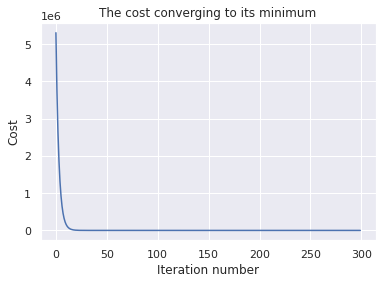


RESULTS

Pearson R -  0.9999091279142763
weights -  [4 4 1 7]
calculated weights -  tensor([[1.9081, 4.1227, 1.1037, 7.1856]], requires_grad=True)


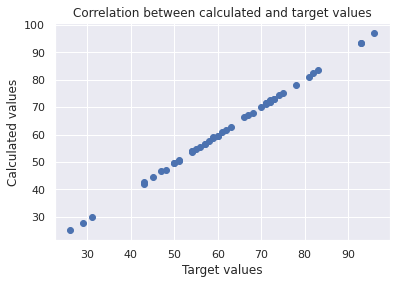

In [19]:
def mv_linear_regression_alg(inputs, targets, loops, alpha):

    # require_grad = True in order to backwards compute derivatives of the weights
    # number of weight coefficients equal to the number of features
    w = torch.randn(1, inputs.shape[1], requires_grad=True)

    print('initial cost - ', cost_func_mv(inputs, targets, w))
    print('Improving parameters...')

    cost_tracker = []

    t_mv1 = time.time()
    for i in range(loops):
        cost = cost_func_mv(inputs, targets, w)
        cost_tracker.append(cost_func_mv(inputs, targets, w).detach().numpy())
        cost.backward()
        with torch.no_grad():
            w -= w.grad * alpha
            w.grad.zero_()
    t_mv2 = time.time()

    print(f'...time taken is {t_mv2 - t_mv1} s to complete {loops} loops')
    print('final cost - ', cost_func_mv(inputs, targets, w))

    return w, cost_tracker

alpha_mv = 1e-5
loops_mv = 3000
w, costs = mv_linear_regression_alg(inputs, targets, loops_mv, alpha_mv)

plt.plot(costs)
plt.title('The cost converging to its minimum')
plt.xlabel('Iteration number')
plt.ylabel('Cost')
plt.ylim(-1000, 1e6)
plt.show()

print('\nRESULTS\n')
df_targets['results'] = linear_func_mv(inputs, w).t().detach().numpy()[0]
print('Pearson R - ', df_targets['target'].corr(df_targets['results']))
print('weights - ', thetai)
print('calculated weights - ', w)

plt.scatter(df_targets['target'].values, df_targets['results'].values)
plt.title('Correlation between calculated and target values')
plt.xlabel('Target values')
plt.ylabel('Calculated values')
plt.show()

The cost function rapidly falls but still needs a lot more iterations to reach a sufficiently low cost to match the input parameters. When plotting the calculated values against the target ones, if they all match we should get a diagonal line of data points (at $y=1x+0$).

In [20]:
df = pd.read_csv('insurance.csv')

instances_tot = df.shape[0]

df_train = df[:int((instances_tot * 4)/5)]
df_test = df[int((instances_tot * 4)/5):]

df_edit = pd.DataFrame()
bias = [1] * int((instances_tot * 4)/5)
df_edit['bias'] = bias
df_edit['smoker'] = df_train['smoker']
df_edit['bmi'] = df_train['bmi']
df_edit['age'] = df_train['age']
df_edit['age^2'] = df_train['age'] ** 2
df_edit['log_charges'] = np.log(df_train['charges'])

df_edit['bmi_cat'] = np.nan
df_edit.loc[df_edit['bmi'] <= 30, 'bmi_cat'] = 0
df_edit.loc[df_edit['bmi'] > 30, 'bmi_cat'] = 1

df_edit['smoker'].replace(('yes', 'no'), (1, 0), inplace=True)
df_edit['age'] = df_edit['age'] / (df_edit['age'].max() - df_edit['age'].min())
df_edit['age^2'] = df_edit['age^2'] / (df_edit['age^2'].max() - df_edit['age^2'].min())
df_edit['bmi'] = df_edit['bmi'] / (df_edit['bmi'].max() - df_edit['bmi'].min())

df_inputs = df_edit.drop('log_charges', axis=1)
df_targets = pd.DataFrame()
df_targets['targets'] = df_edit['log_charges']

print(df_inputs.head())
print(df_targets.head())

   bias  smoker       bmi       age     age^2  bmi_cat
0     1       1  0.761879  0.413043  0.095705      0.0
1     1       0  0.922174  0.391304  0.085896      1.0
2     1       0  0.901147  0.608696  0.207847      1.0
3     1       0  0.620016  0.717391  0.288706      0.0
4     1       0  0.788640  0.695652  0.271474      0.0
    targets
0  9.734176
1  7.453302
2  8.400538
3  9.998092
4  8.260197


Here we set up the health insurance data ready for linear regression.

- The first 'feature' is the bias. Any features which are only 0 or 1 act as a sort of bias only applied to the instances with a 1. The bias will then be whatever weight corresponds to that features. Our 'bias' feature is 1 for every instance and so it acts like a lypical bias.
- The second feature is 'smoker' which is either 0 or 1. This assumes there is a bias which is added for being a smoker.
- 'bmi' and 'age' are both continuous features. These have been scaled to be be at a similar range to the categorical features) by dividing by the range.
- age$^{2}$ is included as a feature as there appears to be some exponential component to the age component to cost. This can be treated as just another linear feature and is again scaled down to the a similar range.
- The final feature is bmi_cat which is whether the bmi is over 30 or not. We saw earlier that, at least for smokers, these two groups seem to be treated differently.
- 'sex', 'region' and number of children have all been omitted as there is very little correlation to charges and in some cases there is a correlation with our chosen features.

The target has been changed to $\log_{e}{charges}$ to give it a more normal distribution.

initial cost -  tensor(68524424., grad_fn=<MulBackward0>)
Improving parameters...
...time taken is 1.7415976524353027 s to complete 10000 loops
final cost -  tensor(116912.6016, grad_fn=<MulBackward0>)

RESULTS



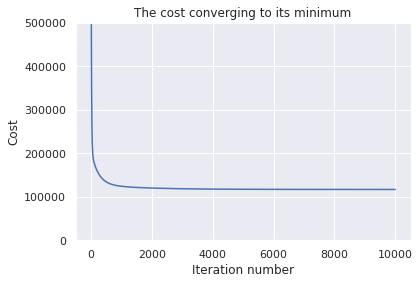

['bias', 'smoker', 'bmi', 'age', 'age^2', 'bmi_cat']
tensor([[ 6.5789,  1.5224,  0.1295,  3.2790, -1.6737,  0.1180]],
       requires_grad=True)
    targets   results
0  9.734176  9.394262
1  7.453302  7.955666
2  8.400538  8.461667
3  9.998092  8.528382
4  8.260197  8.507779
0.8718494069214828


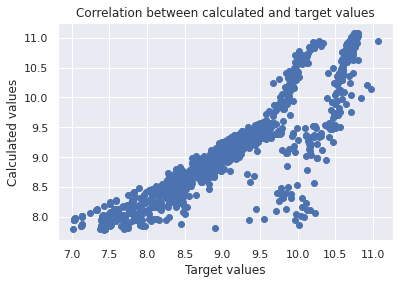

In [21]:
inputs = torch.tensor(df_inputs.values).float()
targets = torch.tensor(df_targets.values).float()
loops = 10000
alpha = 3e-7
w, costs = mv_linear_regression_alg(inputs, targets, loops, alpha)

print('\nRESULTS\n')
plt.plot(costs)
plt.title('The cost converging to its minimum')
plt.xlabel('Iteration number')
plt.ylabel('Cost')
plt.ylim(0, 5e5)
plt.show()
print(df_inputs.columns.tolist())
print(w)
df_targets['results'] = linear_func_mv(inputs, w).detach().numpy()
print(df_targets.head())
print(df_targets['targets'].corr(df_targets['results']))

plt.scatter(df_targets['targets'].values, df_targets['results'].values)
plt.title('Correlation between calculated and target values')
plt.xlabel('Target values')
plt.ylabel('Calculated values')
plt.show()

This fit seemds very good with a Pearson correlation factor of 0.87. The cost function runs down to its minimum consistently showing the gradient descent has worked properly. Our calculated values match the target values reasonably well but there seems to be a couple of trends not quite captured by our model as the error seems systematic. There is also a second group of instances which don't seem to be captured anywhere near as well. 

My theory here is that the smokers and non smokers are treated very differently by the insurance company and there is more than a simple bias between them. For instance, we know that for smokers there is a increase in charge at bmi over 30 but this is not the case for non-smokers. I will therefore split smokers and non smokers, treat them differently and combine them at the end.

In [22]:
df_smokers_i = df_edit[df_edit['smoker'] == 1]
df_smokers_t = pd.DataFrame()
df_smokers_t['targets'] = df_smokers_i['log_charges']
df_smokers_i = df_smokers_i.drop(['log_charges', 'smoker'], axis=1)

print('\nSmokers gradient descent\n')
inputs_s = torch.tensor(df_smokers_i.values).float()
targets_s = torch.tensor(df_smokers_t.values).float()
loops = 10000
alpha = 3e-7
w_s, costs_s = mv_linear_regression_alg(inputs_s, targets_s, loops, alpha)

plt.plot(costs_s)
plt.title('The cost converging to its minimum')
plt.xlabel('Iteration number')
plt.ylabel('Cost')
plt.ylim(0, 5e5)
plt.show()

df_nonsmokers_i = df_edit[df_edit['smoker'] == 0]
df_nonsmokers_t = pd.DataFrame()
df_nonsmokers_t['targets'] = df_nonsmokers_i['log_charges']
df_nonsmokers_i = df_nonsmokers_i.drop(['log_charges', 'smoker'], axis=1)

print('\nNon-smokers gradient descent\n')
inputs_ns = torch.tensor(df_nonsmokers_i.values).float()
targets_ns = torch.tensor(df_nonsmokers_t.values).float()
loops = 10000
alpha = 3e-7
w_ns, costs_ns = mv_linear_regression_alg(inputs_ns, targets_ns, loops, alpha)

plt.plot(costs_ns)
plt.title('The cost converging to its minimum')
plt.xlabel('Iteration number')
plt.ylabel('Cost')
plt.ylim(0, 5e5)
plt.show()

initial cost -  tensor(2234871.2500, grad_fn=<MulBackward0>)
Improving parameters...
...time taken is 1.7453384399414062 s to complete 10000 loops
final cost -  tensor(667.5677, grad_fn=<MulBackward0>)
initial cost -  tensor(49250276., grad_fn=<MulBackward0>)
Improving parameters...
...time taken is 1.737008810043335 s to complete 10000 loops
final cost -  tensor(69029.8125, grad_fn=<MulBackward0>)


Both smokers and non-smokers converge nicely with a gradient descent which always decreases. The final cost for smokers is very low showing we have a very good model for this category. For non-smokers it is not quite so low but is still much lower than the final cost when both categories are treated the same.


SMOKER RESULTS



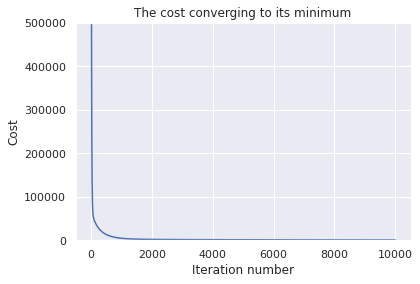

['bias', 'bmi', 'age', 'age^2', 'bmi_cat']
tensor([[ 7.9301,  1.7518,  1.5302, -1.1010,  0.1845]], requires_grad=True)

NON SMOKER RESULTS



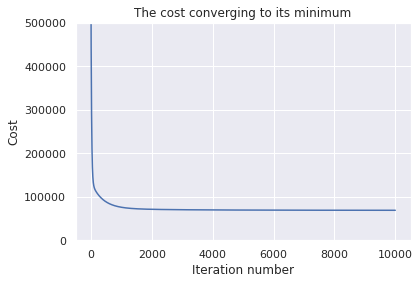

['bias', 'bmi', 'age', 'age^2', 'bmi_cat']
tensor([[ 6.4899, -0.1223,  3.7975, -1.8971,  0.0417]], requires_grad=True)


In [23]:
print('\nSMOKER RESULTS\n')
print(df_smokers_i.columns.tolist())
print(w_s)
df_smokers_t['results'] = linear_func_mv(inputs_s, w_s).detach().numpy()

print('\nNON SMOKER RESULTS\n')
print(df_nonsmokers_i.columns.tolist())
print(w_ns)
df_nonsmokers_t['results'] = linear_func_mv(inputs_ns, w_ns).detach().numpy()

We can see the results of treating these two groups separately. The smoker bias is now shown in the different overall bias for each. The correlation with bmi is completely different with non-smokers having almost no correlatin with bmi. There also appears to be a different correlation with age across the two groups with there being more exponential character in the smokers. This makes sense as smoking related health issues are much more likely to appear in older age. We also see a small bmi>30 bias in the smoker category as we expected.

    targets   results
0  9.734176  9.791407
1  7.453302  7.741840
2  8.400538  8.338598
3  9.998092  8.590679
4  8.260197  8.520200
0.9032967573389259


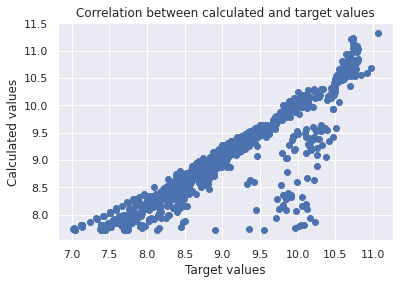

In [24]:
df_final_i = pd.concat([df_nonsmokers_i, df_smokers_i])
df_final_i = df_final_i.sort_index()
df_final_t = pd.concat([df_nonsmokers_t, df_smokers_t])
df_final_t = df_final_t.sort_index()
print(df_final_t.head())
print(df_final_t['targets'].corr(df_final_t['results']))

plt.scatter(df_final_t['targets'].values, df_final_t['results'].values)
plt.title('Correlation between calculated and target values')
plt.xlabel('Target values')
plt.ylabel('Calculated values')
plt.show()

We now see the results of our new model. The line is much more accurately up the middle with some obvious subgroups at the higher charge range. However these have now been treated appropriately as they are falling on the diagonal line. There are still some values which have a much lower calculated value than the target. Based on the cost functions these are probably from the non-smokers primarily and are likely the outliers that we saw before. I could not find anything in the data given to explain these higher charges and so its not surprising that the model does not accurately predict them.

In [25]:
df_targets_test = pd.DataFrame()
df_targets_test['targets'] = df_test['charges']

df_inputs_test = df_test.drop('charges', axis=1)

print(df_inputs_test.head())
print(df_targets_test.head())

      age     sex     bmi  children smoker     region
1070   37    male  37.070         1    yes  southeast
1071   63    male  31.445         0     no  northeast
1072   21    male  31.255         0     no  northwest
1073   54  female  28.880         2     no  northeast
1074   60  female  18.335         0     no  northeast
          targets
1070  39871.70430
1071  13974.45555
1072   1909.52745
1073  12096.65120
1074  13204.28565


We will now look at our test dataframe to give an indication on how we would use our model to predict charges. The data would be given in this form so we will create a function which gives us the appropriate charges from this.

0.9143744841140586


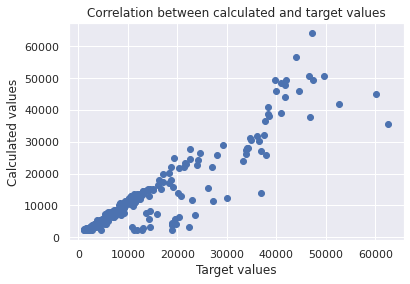

      age     sex     bmi  children smoker     region      charges  \
1070   37    male  37.070         1    yes  southeast  39871.70430   
1071   63    male  31.445         0     no  northeast  13974.45555   
1072   21    male  31.255         0     no  northwest   1909.52745   
1073   54  female  28.880         2     no  northeast  12096.65120   
1074   60  female  18.335         0     no  northeast  13204.28565   

      predicted_charges  
1070       45888.362674  
1071       15220.663748  
1072        2802.251666  
1073       11896.537681  
1074       14340.058955  


In [26]:
def predict_changes(dfin, dfout):
    
    dfin = dfin.reset_index(drop=True)
    dfout = dfout.reset_index(drop=True)
    
    dfout['smoker'] = dfin['smoker']
    
    dfin_edit = pd.DataFrame()
    dfin_edit['bias'] = [1] * dfin.shape[0]
    
    dfin_edit['bmi'] = dfin['bmi']
    dfin_edit['age'] = dfin['age']
    dfin_edit['age^2'] = dfin['age'] ** 2
    dfin_edit['bmi_cat'] = np.nan
    dfin_edit.loc[dfin_edit['bmi'] <= 30, 'bmi_cat'] = 0
    dfin_edit.loc[dfin_edit['bmi'] > 30, 'bmi_cat'] = 1

    dfin_edit['age'] = dfin_edit['age'] / (dfin_edit['age'].max() - dfin_edit['age'].min())
    dfin_edit['age^2'] = dfin_edit['age^2'] / (dfin_edit['age^2'].max() - dfin_edit['age^2'].min())
    dfin_edit['bmi'] = dfin_edit['bmi'] / (dfin_edit['bmi'].max() - dfin_edit['bmi'].min())
    
    dfout['results_log'] = np.nan
    for index, row in dfin_edit.iterrows():
        if dfout.loc[index, 'smoker'] == 'yes':
            xx = torch.tensor(row.values).float()
            dfout.loc[index, 'results_log'] = (xx @ w_s.t()).detach().numpy()[0]
        if dfout.loc[index, 'smoker'] == 'no':
            xx = torch.tensor(row.values).float()
            dfout.loc[index, 'results_log'] = (xx @ w_ns.t()).detach().numpy()[0]

    dfout['results'] = math.e ** dfout['results_log']
    
    print(dfout['targets'].corr(dfout['results']))
    plt.scatter(dfout['targets'].values, dfout['results'].values)
    plt.title('Correlation between calculated and target values')
    plt.xlabel('Target values')
    plt.ylabel('Calculated values')
    plt.show()
    
    # returns the predicted charges as a list (not part of a dataframe)
    return dfout['results'].values


df_test['predicted_charges'] = predict_changes(df_inputs_test, df_targets_test)

print(df_test.head())

A similar process is done here as when our data was first prepared for liner regression. We should have the input data in the same form so that the weights correspond to the appropriate features.

Our predicted values match the target values very well showing we have created a good model for predicting health insurance charges.